### Copy PyTorch cifar10 model to MINIO
Make sure MINIO Setup is done, Refer [minio_setup.ipynb](./minio_setup.ipynb)

In [15]:
%%bash
kubectl cluster-info --context kind-seldon
mc config host add gcs https://storage.googleapis.com "" "" 

mc mb minio-seldon/pytorchcifar10 -p
mc cp gcs/seldon-models/triton/pytorch_cifar10/cifar10 minio-seldon/pytorchcifar10/ --recursive

Kubernetes control plane is running at https://127.0.0.1:57215
CoreDNS is running at https://127.0.0.1:57215/api/v1/namespaces/kube-system/services/kube-dns:dns/proxy

To further debug and diagnose cluster problems, use 'kubectl cluster-info dump'.
Added `gcs` successfully.
Bucket created successfully `minio-seldon/pytorchcifar10`.
`gcs/seldon-models/triton/pytorch_cifar10/cifar10/1/model.pt` -> `minio-seldon/pytorchcifar10/cifar10/1/model.pt`
`gcs/seldon-models/triton/pytorch_cifar10/cifar10/config.pbtxt` -> `minio-seldon/pytorchcifar10/cifar10/config.pbtxt`
Total: 0 B, Transferred: 255.32 KiB, Speed: 221.84 KiB/s


#### Create namespace for experimentation

In [1]:
!kubectl create namespace seldon
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Error from server (AlreadyExists): namespaces "seldon" already exists
Context "kind-seldon" modified.


#### TorchScript CIFAR10 Model


In [20]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf

train, test = tf.keras.datasets.cifar10.load_data()
X_test, y_test = test
X_test = X_test.astype("float32") / 255
print(X_test.shape, y_test.shape)
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

(10000, 32, 32, 3) (10000, 1)


In [21]:
%%writefile secret-custom-triton.yaml
apiVersion: v1
kind: Secret
metadata:
  name: seldon-init-pt-secret
type: Opaque
stringData:
  RCLONE_CONFIG_S3_TYPE: s3
  RCLONE_CONFIG_S3_PROVIDER: minio
  RCLONE_CONFIG_S3_ACCESS_KEY_ID: minioadmin
  RCLONE_CONFIG_S3_SECRET_ACCESS_KEY: minioadmin
  RCLONE_CONFIG_S3_ENDPOINT: http://minio.minio-system.svc.cluster.local:9000
  RCLONE_CONFIG_S3_ENV_AUTH: "false"

Overwriting secret-custom-triton.yaml


In [5]:
!kubectl delete -f secret-custom-triton.yaml
!kubectl create -f secret-custom-triton.yaml

secret "seldon-init-pt-secret" deleted
secret/seldon-init-pt-secret created


In [6]:
%%writefile resources/triton_pt_cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
  namespace: seldon
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: "true"
  name: resnet32
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: s3://pytorchcifar10
      envSecretRefName: seldon-init-pt-secret      
      name: cifar10
      type: MODEL
    name: default
    replicas: 1
  protocol: v2

Overwriting resources/triton_pt_cifar10.yaml


In [7]:
!kubectl delete -f resources/triton_pt_cifar10.yaml
!kubectl create -f resources/triton_pt_cifar10.yaml

Error from server (NotFound): error when deleting "resources/triton_pt_cifar10.yaml": seldondeployments.machinelearning.seldon.io "cifar10" not found
seldondeployment.machinelearning.seldon.io/cifar10 created


In [15]:
### check the pod
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10 -o jsonpath='{.items[0].metadata.name}')

deployment "cifar10-default-0-cifar10" successfully rolled out


##### Test the results.

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=10, shuffle=False, num_workers=2
)
for data in testloader:
    images, labels = data
    break

Files already downloaded and verified


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63672  100   309  100 63363   4717   944k --:--:-- --:--:-- --:--:--  956k


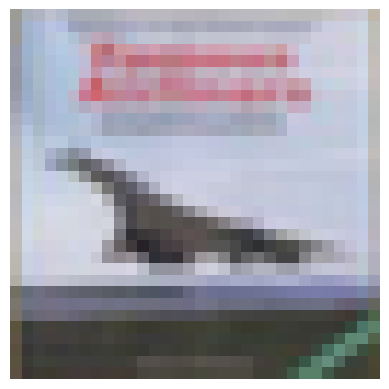

class: airplane
prediction: airplane


In [22]:
import json
from subprocess import PIPE, Popen, run

import numpy as np

idx = 3
test_example = images[idx : idx + 1]
test_example = test_example.tolist()
payload = (
    '{"inputs":[{"name":"input__0","datatype":"FP32","shape":[1, 3, 32, 32],"data":'
    + f"{test_example}"
    + "}]}"
)
cmd = f"""curl -d '{payload}' \
   http://localhost:8004/seldon/seldon/cifar10/v2/models/cifar10/infer \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True, stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res = json.loads(raw)
arr = np.array(res["outputs"][0]["data"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis("off")
plt.show()

print("class:", class_names[labels[idx]])
print("prediction:", class_names[arr.argmax()])

In [25]:
## Scale the Seldon Deployment
!kubectl scale --replicas=4 sdep/cifar10

seldondeployment.machinelearning.seldon.io/cifar10 scaled


In [34]:
## check the deplyments
## References [seldon-core scaling](https://docs.seldon.io/projects/seldon-core/en/latest/graph/scaling.html)
!kubectl get deploy -l seldon-deployment-id=cifar10 -o jsonpath='{.items[0].metadata.name}'

cifar10-default-0-cifar10